In [42]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Splitting 
import os.path
import argparse
import random
import datetime as dt
import copy

# Data Augmentation 
import PIL
import cv2
import glob
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import os

### Use Keras Model Architecture 

In [66]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers, optimizers
from keras.optimizers import SGD,Adam
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow as tf

In [77]:
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

### Dataset Preparation 

In [45]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [46]:
# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [47]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [48]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [49]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [50]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


In [51]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [52]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [53]:
df.head()

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000006.jpg,Glass bottle,517.0,127.0,447.0,1322.0
1,batch_1/000012.jpg,Glass bottle,379.0,1127.0,425.0,318.0
2,batch_1/000048.jpg,Glass bottle,211.0,1.0,417.0,1417.0
3,batch_1/000021.jpg,Glass bottle,852.0,638.0,687.0,291.0
4,batch_1/000022.jpg,Glass bottle,647.0,1033.0,820.0,376.0


In [54]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min']
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)
    

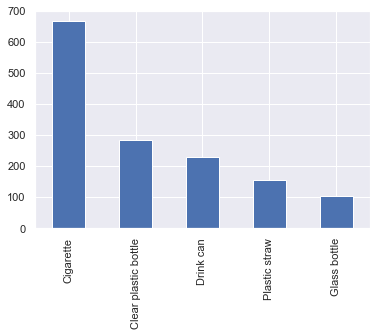

In [55]:
df['category'].value_counts().plot.bar()

In [56]:
df['category'].value_counts()

Cigarette               667
Clear plastic bottle    285
Drink can               229
Plastic straw           157
Glass bottle            104
Name: category, dtype: int64

### Fetch, crop and store image data

In [57]:
# Reading all the images from multiple folders and added to the list
folders = glob.glob(dataset_path +'//*')
imagenames_list = []
for folder in folders:
    for f in glob.glob(folder+'/*'):   
        imagenames_list.append(f)

In [59]:
train_data = []  
for ind in df.index:
    bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
    img=Image.open(os.path.join(dataset_path,df['filename'][ind]))
    img=img.crop(bbox)
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = image.img_to_array(img)
    train_data.append(img)

X = np.array(train_data)

In [60]:
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)

In [61]:
df.head()

,filename,category
0,batch_1/000006.jpg,Glass bottle
1,batch_1/000012.jpg,Glass bottle
2,batch_1/000048.jpg,Glass bottle
3,batch_1/000021.jpg,Glass bottle
4,batch_1/000022.jpg,Glass bottle


In [62]:
df1 = pd.get_dummies(df, columns=["category"])
df1.head()

,filename,category_Cigarette,category_Clear plastic bottle,category_Drink can,category_Glass bottle,category_Plastic straw
0,batch_1/000006.jpg,0,0,0,1,0
1,batch_1/000012.jpg,0,0,0,1,0
2,batch_1/000048.jpg,0,0,0,1,0
3,batch_1/000021.jpg,0,0,0,1,0
4,batch_1/000022.jpg,0,0,0,1,0


In [63]:
# 
y = np.array(df1.drop(['filename'],axis=1))
print(y.shape)
print(X.shape)

(1442, 5)
(1442, 128, 128, 3)


### Data Split 

In [83]:
# Data split Randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

### Build Model using k-fold technique

In [106]:
def modelCreation():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #
    return model

In [109]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=modelCreation, epochs=50, batch_size=30, verbose=1)
# evaluate using 10-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

Epoch 1/50
922/922 [==============================] - 29s 31ms/step - loss: 18.9776 - accuracy: 0.3221
Epoch 2/50
922/922 [==============================] - 21s 23ms/step - loss: 1.3737 - accuracy: 0.4555
Epoch 3/50
922/922 [==============================] - 20s 21ms/step - loss: 1.3079 - accuracy: 0.4534
Epoch 4/50
922/922 [==============================] - 19s 21ms/step - loss: 1.2946 - accuracy: 0.4761
Epoch 5/50
922/922 [==============================] - 20s 22ms/step - loss: 1.2287 - accuracy: 0.4924
Epoch 6/50
922/922 [==============================] - 22s 24ms/step - loss: 1.2355 - accuracy: 0.4913
Epoch 7/50
922/922 [==============================] - 20s 22ms/step - loss: 1.2238 - accuracy: 0.4946
Epoch 8/50
922/922 [==============================] - 22s 24ms/step - loss: 1.2178 - accuracy: 0.5206
Epoch 9/50
922/922 [==============================] - 22s 23ms/step - loss: 1.2052 - accuracy: 0.5108
Epoch 10/50
922/922 [==============================] - 20s 22ms/step - loss: 1.17

922/922 [==============================] - 27s 29ms/step - loss: 1.0810 - accuracy: 0.5965
Epoch 31/50
922/922 [==============================] - 24s 26ms/step - loss: 1.0315 - accuracy: 0.5900
Epoch 32/50
922/922 [==============================] - 25s 27ms/step - loss: 1.0375 - accuracy: 0.6030
Epoch 33/50
922/922 [==============================] - 22s 23ms/step - loss: 1.0479 - accuracy: 0.5987
Epoch 34/50
922/922 [==============================] - 21s 22ms/step - loss: 1.0258 - accuracy: 0.6030
Epoch 35/50
922/922 [==============================] - 26s 28ms/step - loss: 1.0295 - accuracy: 0.5998
Epoch 36/50
922/922 [==============================] - 22s 24ms/step - loss: 1.0239 - accuracy: 0.6020
Epoch 37/50
922/922 [==============================] - 21s 23ms/step - loss: 1.0057 - accuracy: 0.6139
Epoch 38/50
922/922 [==============================] - 22s 24ms/step - loss: 0.9962 - accuracy: 0.6182
Epoch 39/50
922/922 [==============================] - 20s 22ms/step - loss: 0.9566 -

923/923 [==============================] - 21s 23ms/step - loss: 1.1356 - accuracy: 0.5601
Epoch 9/50
923/923 [==============================] - 19s 21ms/step - loss: 1.1396 - accuracy: 0.5655
Epoch 10/50
923/923 [==============================] - 32s 35ms/step - loss: 1.1146 - accuracy: 0.5775
Epoch 11/50
923/923 [==============================] - 29s 32ms/step - loss: 1.0943 - accuracy: 0.5829
Epoch 12/50
923/923 [==============================] - 21s 23ms/step - loss: 1.1010 - accuracy: 0.5731
Epoch 13/50
923/923 [==============================] - 27s 29ms/step - loss: 1.1218 - accuracy: 0.5807
Epoch 14/50
923/923 [==============================] - 19s 21ms/step - loss: 1.0769 - accuracy: 0.5872
Epoch 15/50
923/923 [==============================] - 20s 22ms/step - loss: 1.1380 - accuracy: 0.5688
Epoch 16/50
923/923 [==============================] - 20s 21ms/step - loss: 1.0730 - accuracy: 0.5894
Epoch 17/50
923/923 [==============================] - 24s 26ms/step - loss: 1.0652 - 

923/923 [==============================] - 22s 24ms/step - loss: 1.0772 - accuracy: 0.5775
Epoch 38/50
923/923 [==============================] - 21s 23ms/step - loss: 1.0432 - accuracy: 0.5980
Epoch 39/50
923/923 [==============================] - 20s 22ms/step - loss: 1.0600 - accuracy: 0.5720
Epoch 40/50
923/923 [==============================] - 20s 21ms/step - loss: 1.0299 - accuracy: 0.5840
Epoch 41/50
923/923 [==============================] - 19s 20ms/step - loss: 1.0174 - accuracy: 0.6056
Epoch 42/50
923/923 [==============================] - 22s 24ms/step - loss: 1.0259 - accuracy: 0.5872
Epoch 43/50
923/923 [==============================] - 33s 36ms/step - loss: 1.0347 - accuracy: 0.5970
Epoch 44/50
923/923 [==============================] - 27s 29ms/step - loss: 1.0305 - accuracy: 0.5883
Epoch 45/50
923/923 [==============================] - 25s 27ms/step - loss: 1.0128 - accuracy: 0.6035
Epoch 46/50
923/923 [==============================] - 26s 28ms/step - loss: 1.0108 -